# Segmentation of Indian Traffic

In [1]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Mounted at /gdrive
/gdrive


In [2]:
import math
from PIL import Image, ImageDraw
from PIL import ImagePath
import pandas as pd
import os
from os import path
from tqdm import tqdm
import json
import cv2
import numpy as np
import matplotlib.pyplot as plt
import urllib
import urllib.request


<pre>
1. You can download the data from this link, and extract it

2. All your data will be in the folder "data" 

3. Inside the data you will be having two folders

|--- data
|-----| ---- images
|-----| ------|----- Scene 1
|-----| ------|--------| ----- Frame 1 (image 1)
|-----| ------|--------| ----- Frame 2 (image 2)
|-----| ------|--------| ----- ...
|-----| ------|----- Scene 2
|-----| ------|--------| ----- Frame 1 (image 1)
|-----| ------|--------| ----- Frame 2 (image 2)
|-----| ------|--------| ----- ...
|-----| ------|----- .....
|-----| ---- masks
|-----| ------|----- Scene 1
|-----| ------|--------| ----- json 1 (labeled objects in image 1)
|-----| ------|--------| ----- json 2 (labeled objects in image 1)
|-----| ------|--------| ----- ...
|-----| ------|----- Scene 2
|-----| ------|--------| ----- json 1 (labeled objects in image 1)
|-----| ------|--------| ----- json 2 (labeled objects in image 1)
|-----| ------|--------| ----- ...
|-----| ------|----- .....
</pre>

# Task 1: Preprocessing

## 1. Get all the file name and corresponding json files

In [3]:
os.chdir('/gdrive/My Drive/Image_Segmentation/segmentation')
os.listdir()

['data',
 'Preprocessing.csv',
 'logs',
 'Model_save',
 'Segmentation_Assignment.ipynb',
 'tf_ckpts',
 'Copy of Segmentation_Assignment.ipynb',
 'test_image.png',
 'Preprocessing_2.csv',
 'preprocessed_data.csv',
 'Reference_Preptrained_Unet.ipynb',
 'model4.png',
 'model.png',
 'Model_save_CANET',
 'best_model_CANET.hdf5',
 'best_model_CANET.h5']

In [ ]:
# First check both image and Mask folder contains same number of sub-folder with same name respectively
image_sub_folder = sorted(os.listdir('data/images'))
mask_sub_folder = sorted(os.listdir('data/mask'))
print('Length of image folder',len(image_sub_folder))
print('Length of image folder',len(mask_sub_folder))
print('Both Image and Mask contains same folder names - ',image_sub_folder == (mask_sub_folder))

Length of image folder 143
Length of image folder 143
Both Image and Mask contains same folder names -  True


In [ ]:
def return_file_names_df():
    # write the code that will create a dataframe with two columns ['images', 'json']
    # the column 'image' will have path to images
    # the column 'json' will have path to json files
    img_path = []
    mask_path = []

    for i in tqdm(image_sub_folder):
      img_loc = sorted(os.listdir('data/images/'+str(i)))
      mask_loc = sorted(os.listdir('data/mask/'+str(i)))

      for file_I,file_M in zip(img_loc,mask_loc):
        img_pa = os.path.join('data/images/'+str(i),file_I)
        mask_pa = os.path.join('data/mask/'+str(i),file_M)
        img_path.append(img_pa)
        mask_path.append(mask_pa)

    data_df = pd.DataFrame({'image': img_path,'json': mask_path})

    
    return data_df

In [ ]:
data_df = return_file_names_df()
data_df.head()

100%|██████████| 143/143 [00:09<00:00, 15.24it/s]


,image,json
0,data/images/201/frame0029_leftImg8bit.jpg,data/mask/201/frame0029_gtFine_polygons.json
1,data/images/201/frame0299_leftImg8bit.jpg,data/mask/201/frame0299_gtFine_polygons.json
2,data/images/201/frame0779_leftImg8bit.jpg,data/mask/201/frame0779_gtFine_polygons.json
3,data/images/201/frame1019_leftImg8bit.jpg,data/mask/201/frame1019_gtFine_polygons.json
4,data/images/201/frame1469_leftImg8bit.jpg,data/mask/201/frame1469_gtFine_polygons.json


> If you observe the dataframe, we can consider each row as single data point, where first feature is image and the second feature is corresponding json file

In [ ]:

def grader_1(data_df):
    for i in data_df.values:
        if not (path.isfile(i[0]) and path.isfile(i[1]) and i[0][12:i[0].find('_')]==i[1][10:i[1].find('_')]):
            return False
    return True

In [ ]:
grader_1(data_df)

True

In [ ]:
data_df.shape

(4008, 2)

## 2. Structure of sample Json file

<img src='https://i.imgur.com/EfR5KmI.png' width="200" height="100">

* Each File will have 3 attributes
    * imgHeight: which tells the height of the image
    * imgWidth: which tells the width of the image
    * objects: it is a list of objects, each object will have multiple attributes,
        * label: the type of the object
        * polygon: a list of two element lists, representing the coordinates of the polygon

#### Compute the unique labels

Let's see how many unique objects are there in the json file.
to see how to get the object from the json file please check <a href='https://www.geeksforgeeks.org/read-json-file-using-python/'>this blog </a>

In [ ]:
def return_unique_labels(data_df):
    # for each file in the column json
    #       read and store all the objects present in that file
    # compute the unique objects and retrun them
    # if open any json file using any editor you will get better sense of it
    all_attributes = [] # storing all attributes
    all_labels = [] # stroing all label values of each row
    
    for i in tqdm(range(data_df.shape[0])):
      f = open(data_df.json[i],) 
      data = json.load(f) 
      for j in data['objects']:
        all_attributes.append(j)
      f.close()

    # to get unique label count
    for k in tqdm(range(len(all_attributes))):
     all_labels.append( all_attributes[k]['label'])


    # get unique 
    unique_labels = list(set(all_labels))
    print('Number of unique labels ',len(unique_labels))

    return unique_labels

In [ ]:
unique_labels = return_unique_labels(data_df)

<img src='https://i.imgur.com/L4QH6Tp.png'>

In [4]:
label_clr = {'road':10, 'parking':20, 'drivable fallback':20,'sidewalk':30,'non-drivable fallback':40,'rail track':40,\
                        'person':50, 'animal':50, 'rider':60, 'motorcycle':70, 'bicycle':70, 'autorickshaw':80,\
                        'car':80, 'truck':90, 'bus':90, 'vehicle fallback':90, 'trailer':90, 'caravan':90,\
                        'curb':100, 'wall':100, 'fence':110,'guard rail':110, 'billboard':120,'traffic sign':120,\
                        'traffic light':120, 'pole':130, 'polegroup':130, 'obs-str-bar-fallback':130,'building':140,\
                        'bridge':140,'tunnel':140, 'vegetation':150, 'sky':160, 'fallback background':160,'unlabeled':0,\
                        'out of roi':0, 'ego vehicle':170, 'ground':180,'rectification border':190,\
                   'train':200}

In [5]:
class_values = sorted(list(set(label_clr.values())))
print('Class labels', class_values)
class_values = [int(x / 10 )for x in class_values]
print('Class labels', class_values)
print('Number of unique class labels',len(set(label_clr.values())))

Class labels [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200]
Class labels [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Number of unique class labels 21


In [ ]:
def grader_2(unique_labels):
    if (not (set(label_clr.keys())-set(unique_labels))) and len(unique_labels) == 40:
        print("True")
    else:
        print("Flase")

grader_2(unique_labels)

True


<pre>
* here we have given a number for each of object types, if you see we are having 21 different set of objects
* Note that we have multiplies each object's number with 10, that is just to make different objects look differently in the segmentation map
* Before you pass it to the models, you might need to devide the image array /10.
</pre>

## 3. Extracting the polygons from the json files

In [ ]:
def get_poly(file):
 
    f = open(file,)
    data = json.load(f)
    label,vertexlist=[],[]
    for obj in data['objects']:
        label.append(obj['label'])
        vertexlist.append([tuple(vertex) for vertex in obj['polygon']])
    w= data['imgWidth']
    h=data['imgHeight']

    return w, h, label, vertexlist

In [ ]:
w, h, labels, vertexlist = get_poly('data/mask/201/frame0029_gtFine_polygons.json')

In [ ]:
def grader_3(file):

  w, h, labels, vertexlist = get_poly(file)
  print(len((set(labels)))==18 and len(vertexlist)==227 and w==1920 and h==1080 \
        and isinstance(vertexlist,list) and isinstance(vertexlist[0],list) and isinstance(vertexlist[0][0],tuple) )

grader_3('data/mask/201/frame0029_gtFine_polygons.json')

True


## 4. Creating Image segmentations by drawing set of polygons

### Example

Before <PIL.ImageDraw.ImageDraw object at 0x7fc5eb03f5c0>
After <PIL.ImageDraw.ImageDraw object at 0x7fc5eb03f5c0>
(28, 28, 3)
[[0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
 [0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
 [0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 6 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 6 6 6 6 6 6 6 6 6 6 6 6 6 6 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 6 6 6 6 6 6 6 6 6 6 6 6

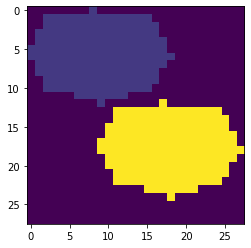

In [ ]:
import math 
from PIL import Image, ImageDraw 
from PIL import ImagePath  
side=8
x1 = [ ((math.cos(th) + 1) *9, (math.sin(th) + 1) * 6) for th in [i * (2 * math.pi) / side for i in range(side)] ]
x2 = [ ((math.cos(th) + 2) *9, (math.sin(th) + 3) *6) for th in [i * (2 * math.pi) / side for i in range(side)] ]

img = Image.new("RGB", (28,28))
img1 = ImageDraw.Draw(img)
print('Before',img1)
# please play with the fill value
# writing the first polygon
img1.polygon(x1, fill =10)
# writing the second polygon
img1.polygon(x2, fill =60)
print('After',img1)

img=np.array(img)
# note that the filling of the values happens at the channel 1, so we are considering only the first channel here
plt.imshow(img[:,:,0])
print(img.shape)
print(img[:,:,0]//10)
im = Image.fromarray(img[:,:,0])
im.save("test_image.png")

In [ ]:
#os.makedirs('data/output')
def compute_masks(data_df):
    mask=[]
    for file in tqdm(data_df['json']):
        w, h, labels, vertexlist = get_poly(file)

        img= Image.new("RGB",(w,h)) 
        img1 = ImageDraw.Draw(img)
        for i in range(len(labels)):
            if(len(vertexlist[i])>1):
                img1.polygon(vertexlist[i], fill = label_clr[labels[i]])
        img=np.array(img)
        im = Image.fromarray(img[:,:,0])
        new_file=file.replace('mask','output')
        new_file=new_file.replace('json','png')
        os.makedirs('data/output/'+file.split('/')[2],exist_ok=True)
        im.save(new_file)
        mask.append(new_file)
    data_df['mask']=mask
    
    return data_df


In [ ]:
data_df = compute_masks(data_df)

100%|██████████| 4008/4008 [05:14<00:00, 12.75it/s]


In [ ]:
data_df.head(5)

,image,json,mask
0,data/images/201/frame0029_leftImg8bit.jpg,data/mask/201/frame0029_gtFine_polygons.json,data/output/201/frame0029_gtFine_polygons.png
1,data/images/201/frame0299_leftImg8bit.jpg,data/mask/201/frame0299_gtFine_polygons.json,data/output/201/frame0299_gtFine_polygons.png
2,data/images/201/frame0779_leftImg8bit.jpg,data/mask/201/frame0779_gtFine_polygons.json,data/output/201/frame0779_gtFine_polygons.png
3,data/images/201/frame1019_leftImg8bit.jpg,data/mask/201/frame1019_gtFine_polygons.json,data/output/201/frame1019_gtFine_polygons.png
4,data/images/201/frame1469_leftImg8bit.jpg,data/mask/201/frame1469_gtFine_polygons.json,data/output/201/frame1469_gtFine_polygons.png


In [ ]:
data_df.to_csv('Preprocessing_2.csv',index=False)

True
[  0  10  20  40  50  60  70  80  90 100 120 130 140 150 160]
[  0  10  20  40  50  60  70  80  90 100 120 130 140 150 160]


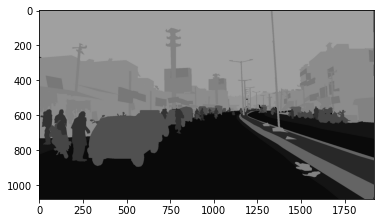

In [ ]:
def grader_3():
    url = "https://i.imgur.com/4XSUlHk.png"
    url_response = urllib.request.urlopen(url)
    img_array = np.array(bytearray(url_response.read()), dtype=np.uint8)
    img = cv2.imdecode(img_array, -1)
    my_img = cv2.imread('data/output/201/frame0029_gtFine_polygons.png')   
    plt.imshow(my_img)
    print((my_img[:,:,0]==img).all())
    print(np.unique(img))
    print(np.unique(my_img[:,:,0]))
    #print(my_img[:,:,0])
    data_df.to_csv('preprocessed_data.csv', index=False)
grader_3()

# Note image should be in png , otherwise(.jpg) this grader function get fail but segmentation will happen correctly.

In [6]:
data_df = pd.read_csv('preprocessed_data.csv')
data_df.drop(['Unnamed: 0','json'],inplace=True,axis=1)
data_df.head(2)

,image,mask
0,data/images/201/frame0029_leftImg8bit.jpg,data/output/201/frame0029_gtFine_polygons.png
1,data/images/201/frame0299_leftImg8bit.jpg,data/output/201/frame0299_gtFine_polygons.png


# Task 2: Applying Unet to segment the images

**Channels Last** <pre>. Image data is represented in a three-dimensional array where the last channel represents the color channels, e.g. [rows][cols][channels] </pre>

**Channels First**
<pre>
Image data is represented in a three-dimensional array where the first channel represents the color channels, e.g. [channels][rows][cols].
</pre>

<pre>
* please check the paper: https://arxiv.org/abs/1505.04597

* <img src='https://i.imgur.com/rD4yP7J.jpg' width="500">

* As a part of this assignment we won't writingt this whole architecture, rather we will be doing transfer learning

* please check the library <a hreaf='https://github.com/qubvel/segmentation_models'>https://github.com/qubvel/segmentation_models</a>

* You can install it like this "pip install -U segmentation-models==0.2.1", even in google colab you can install the    same with "!pip install -U segmentation-models==0.2.1" 

* Check the reference notebook in which we have solved one end to end case study of image forgery detection using same  unet

* The number of channels in the output will depend on the number of classes in your data, since we know that we are having 21 classes, the number of channels in the output will also be 21

* <strong>This is where we want you to explore, how do you featurize your created segmentation map note that the original map will be of (w, h, 1) and the output will be (w, h, 21) how will you calculate the loss</strong>, you can check the examples in segmentation github

* please use the loss function that is used in the refence notebooks

</pre>

In [7]:
!pip install tensorflow==2.2.0

     |████████████████████████████████| 516.2MB 31kB/s 
     |████████████████████████████████| 3.0MB 39.7MB/s 
     |████████████████████████████████| 460kB 37.0MB/s 
  Found existing installation: tensorboard 2.3.0
    Uninstalling tensorboard-2.3.0:
      Successfully uninstalled tensorboard-2.3.0
  Found existing installation: tensorflow-estimator 2.3.0
    Uninstalling tensorflow-estimator-2.3.0:
      Successfully uninstalled tensorflow-estimator-2.3.0
  Found existing installation: tensorflow 2.3.0
    Uninstalling tensorflow-2.3.0:
      Successfully uninstalled tensorflow-2.3.0


In [8]:
!pip install keras==2.3.1

     |████████████████████████████████| 378kB 2.8MB/s 
     |████████████████████████████████| 51kB 5.9MB/s 
  Found existing installation: Keras 2.4.3
    Uninstalling Keras-2.4.3:
      Successfully uninstalled Keras-2.4.3


In [9]:
!pip install -U segmentation-models==0.2.1

     |████████████████████████████████| 51kB 1.7MB/s 
     |████████████████████████████████| 81kB 4.3MB/s 


In [10]:
# install required Package
import tensorflow as tf
# tf.enable_eager_execution()
import os
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
# from hilbert import hilbertCurve
import imgaug.augmenters as iaa
import numpy as np
# import albumentations as A
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
from tensorflow.keras import layers,Model
from tensorflow.keras.layers import Dense,Input,Conv2D,MaxPool2D,Activation,Dropout,Flatten, BatchNormalization, ReLU, Reshape,Flatten
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler, ReduceLROnPlateau, TensorBoard

from tensorflow.keras.models import Model
import random as rn

In [11]:
# here dir_path is the route directory where all the images and segmentation maps are there
dir_path = "data/images/"
dir_path_output = "data/output/"
file_names = set()
file_names_output = set()
for folder in tqdm(os.listdir(dir_path)):

    dir_paths = "data/images/" +str(folder)
    for i in os.listdir(dir_paths):
      path= (i.split('.')[0].split('_')[0])
      file_names.add(str(folder) +str('/')+path)



for folder in tqdm(os.listdir(dir_path_output)):
    dir_paths = "data/output/" +str(folder)
    for i in os.listdir(dir_paths):
      path= (i.split('.')[0].split('_')[0])
      file_names_output.add(str(folder) +str('/')+path)


100%|██████████| 143/143 [00:18<00:00,  7.78it/s]


In [12]:
print('Total_number of unique files', len(file_names))
print('Total_number of unique files- Output Mask folder', len(file_names_output))

Total_number of unique files 4008
Total_number of unique files- Output Mask folder 4008


In [13]:
from sklearn.model_selection import train_test_split
X_train, X_test = train_test_split(list(file_names), test_size=0.20, random_state=42)

In [14]:
X_train[:5]

['237/frame52930',
 '376/frame1866',
 '333/frame0389',
 '236/frame36799',
 '417/0002149']

In [15]:
# install required Package
import tensorflow as tf
# tf.enable_eager_execution()
import os
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
# from hilbert import hilbertCurve
import imgaug.augmenters as iaa
import numpy as np
# import albumentations as A
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
from tensorflow.keras import layers,Model
from tensorflow.keras.layers import Dense,Input,Conv2D,MaxPool2D,Activation,Dropout,Flatten, BatchNormalization, ReLU, Reshape,Flatten
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler, ReduceLROnPlateau, TensorBoard

from tensorflow.keras.models import Model
import random as rn

In [16]:
# we are importing the pretrained unet from the segmentation models
# https://github.com/qubvel/segmentation_models
import segmentation_models as sm

tf.keras.backend.set_image_data_format('channels_last')

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/classification_models/resnext/__init__.py:4: UserWarning: Current ResNext models are deprecated, use keras.applications ResNeXt models
  warnings.warn('Current ResNext models are deprecated, '


In [17]:
# import imgaug.augmenters as iaa
# For the assignment choose any 4 augumentation techniques
# check the imgaug documentations for more augmentations
aug2 = iaa.Fliplr(1)
aug3 = iaa.Flipud(1)
aug4 = iaa.Emboss(alpha=(1), strength=1)
aug5 = iaa.DirectedEdgeDetect(alpha=(0.8), direction=(1.0))

In [18]:
def visualize(**images):
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        if i==1:
            plt.imshow(image, cmap='gray', vmax=1, vmin=0)
        else:
            plt.imshow(image)
    plt.show()

def normalize_image(mask):
    mask = mask/255
    return mask
    

class Dataset:
    # we will be modifying this CLASSES according to your data/problems
    #CLASSES = class_values
    CLASSES = list(np.unique(list(label_clr.values()))) 
    #classes=CLASSES
    
    # the parameters needs to changed based on your requirements
    # here we are collecting the file_names because in our dataset, both our images and maks will have same file name
    # ex: fil_name.jpg   file_name.mask.jpg
    def __init__(self, images_dir,images_dir_mask ,file_names,classes):
        print(classes)
        
        self.ids = file_names
        # the paths of images
        self.images_fps   = [os.path.join(images_dir, image_id+'_leftImg8bit.jpg') for image_id in self.ids]
        # the paths of segmentation images
        self.masks_fps    = [os.path.join(images_dir_mask, image_id+"_gtFine_polygons.png") for image_id in self.ids]
        # giving labels for each class
        #self.class_values = [self.CLASSES.index(cls) for cls in classes]
        self.class_values = CLASSES
        print(self.class_values)

    def __getitem__(self, i):
        
        # read data
        #print('Reading a data')

        image = cv2.imread(self.images_fps[i], cv2.IMREAD_UNCHANGED)
        image = cv2.resize(image, (256, 256),interpolation=cv2.INTER_AREA) 
        #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask  = cv2.imread(self.masks_fps[i], cv2.IMREAD_UNCHANGED)
        mask = cv2.resize(mask, (256, 256),interpolation=cv2.INTER_AREA) 

        image_mask = mask
      
        image_masks = [(image_mask == v) for v in self.class_values]
        image_mask = np.stack(image_masks, axis=-1).astype('float')
        #print('MASK',image_mask.shape)

        if self.isTest == False:
            a = np.random.uniform()

            if a<0.2:
                image = aug2.augment_image(image)
                #image_mask = aug2.augment_image(image_mask)
            elif a<0.4:
                image = aug3.augment_image(image)
                #image_mask = aug3.augment_image(image_mask)
            elif a<0.6:
                image = aug4.augment_image(image)
                #image_mask = aug4.augment_image(image_mask)
            else:
                image = aug5.augment_image(image)
                #image_mask = image_mask

            
        return image, image_mask
        
    def __len__(self):
        return len(self.ids)
    
    
class Dataloder(tf.keras.utils.Sequence):    
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])
        
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        #print(type(batch))
        
        return tuple(batch)
    
    def __len__(self):
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)

In [19]:
# Dataset for train images
CLASSES = list(np.unique(list(label_clr.values()))) 
train_dataset = Dataset(dir_path,dir_path_output,X_train, classes=CLASSES,isTest=False)
test_dataset  = Dataset(dir_path,dir_path_output,X_test, classes=CLASSES,isTest=True)



[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200]
[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200]
[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200]
[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200]


In [20]:
# CANET
train_dataloader = Dataloder(train_dataset, batch_size=32, shuffle=True)
test_dataloader = Dataloder(test_dataset, batch_size=32, shuffle=True)

print(train_dataloader[0][0].shape)

(32, 256, 256, 3)


In [ ]:
print(test_dataloader[0][0].shape)

(32, 256, 256, 3)


In [ ]:
print(train_dataloader)
print(test_dataloader)

### Task 2.2: Training Unet


<pre>
* Split the data into 80:20.
* Train the UNET on the given dataset and plot the train and validation loss.
* As shown in the reference notebook plot 20 images from the test data along with its segmentation map, predicted map.
</pre>

# Task 3: Training CANet

In [21]:
import tensorflow as tf
# tf.compat.v1.enable_eager_execution()
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import UpSampling2D
from tensorflow.keras.layers import MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import Multiply
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.activations import relu
K.set_image_data_format('channels_last')
K.set_learning_phase(1)

* as a part of this assignment we will be implementing the architecture based on this paper https://arxiv.org/pdf/2002.12041.pdf
* We will be using the custom layers concept that we used in seq-seq assignment
* You can devide the whole architecture can be devided into two parts
    1. Encoder
    2. Decoder
    <img src='https://i.imgur.com/prH3Mno.png' width="600">
* Encoder:
    * The first step of the encoder is to create the channel maps [$C_1$, $C_2$, $C_3$, $C_4$]
    * $C_1$ width and heigths are 4x times less than the original image
    * $C_2$ width and heigths are 8x times less than the original image
    * $C_3$ width and heigths are 8x times less than the original image
    * $C_4$ width and heigths are 8x times less than the original image
    * <i>you can reduce the dimensions by using stride parameter</i>.
    * [$C_1$, $C_2$, $C_3$, $C_4$] are formed by applying a "conv block" followed by $k$ number of "identity block". i.e the $C_k$ feature map will single "conv block" followed by $k$ number of "identity blocks".
    <table>
    <tr><td><img src="https://i.imgur.com/R8Gdypo.png" width="300"></td>
        <td><img src="https://i.imgur.com/KNunjQK.png" width="250"></td></tr>
    </table>
    * <strong>The conv block and identity block of $C_1$</strong>: the number filters in the covolutional layers will be $[4,4,8]$ and the number of filters in the parallel conv layer will also be $8$.
    * <strong>The conv block and identity block of $C_2$</strong>: the number filters in the covolutional layers will be $[8,8,16]$ and the number of filters in the parallel conv layer will also be $16$.
    * <strong>The conv block and identity block of $C_3$</strong>: the number filters in the covolutional layers will be $[16,16,32]$ and the number of filters in the parallel conv layer will also be $32$.
    * <strong>The conv block and identity block of $C_4$</strong>: the number filters in the covolutional layers will be $[32,32,64]$ and the number of filters in the parallel conv layer will also be $64$.
    * Here $\oplus$ represents the elementwise sum
    <br>
    
    <font color="red">NOTE: these filters are of your choice, you can explore more options also</font>
    
    * Example: if your image is of size $(512, 512, 3)$
        * the output after $C_1$ will be $128*128*8$
        * the output after $C_2$ will be $64*64*16$
        * the output after $C_3$ will be $64*64*32$
        * the output after $C_4$ will be $64*64*64$

* The output of the $C_4$ will be passed to $\text{Chained Context Aggregation Module (CAM)}$
<img src='https://i.imgur.com/Bu63AAA.png' width="400">
* The CAM module will have two operations names Context flow and Global flow
* <strong>The Global flow</strong>: 
    * as shown in the above figure first we willl apply  <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalAveragePooling2D">global avg pooling</a> which results in (#, 1, 1, number_of_filters) then applying <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/BatchNormalization?version=nightly">BN</a>, <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/ReLU">RELU</a>, $1*1 \text{ Conv}$ layer sequentially which results a matrix (#, 1, 1, number_of_filters). Finally apply <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/UpSampling2D">upsampling</a> / <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2DTranspose">conv2d transpose</a> to make the output same as the input dimensions (#, input_height, input_width, number_of_filters)
    * If you use <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/UpSampling2D">upsampling</a> then use bilinear pooling as interpolation technique
* <strong>The Context flow</strong>: 
    * as shown in the above figure (c) the context flow will get inputs from two modules `a. C4` `b. From the above flow` 
    * We will be <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/Concatenate">concatinating</a> the both inputs on the last axis.
    * After the concatination we will be applying <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/AveragePooling2D"> Average pooling </a> which reduces the size of feature map by $N\times$ times
    * In the paper it was mentioned that to apply a group convolutions, but for the assignment we will be applying the simple conv layers with kernel size $(3*3)$
    * We are skipping the channel shuffling 
    * similarly we will be applying a simple conv layers with kernel size $(3*3)$ consider this output is X
    * later we will get the Y=(X $\otimes \sigma((1\times1)conv(relu((1\times1)conv(X))))) \oplus X$, here $\oplus$ is elementwise addition and $\otimes$ is elementwise multiplication
    * Finally apply <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/UpSampling2D">upsampling</a> / <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2DTranspose">conv2d transpose</a> to make the output same as the input dimensions (#, input_height, input_width, number_of_filters)
    * If you use <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/UpSampling2D">upsampling</a> then use bilinear pooling as interpolation technique

NOTE: here N times reduction and N time increments makes the input and out shape same, you can explore with the N values, you can choose N = 2 or 4

* Example with N=2:
    * Assume the C4 is of shape (64,64,64) then the shape of GF will be (64,64,32)
    * Assume the C4 is of shape (64,64,64) and the shape of GF is (64,64,32) then the shape of CF1 will be (64,64,32)
    * Assume the C4 is of shape (64,64,64) and the shape of CF1 is (64,64,32) then the shape of CF2 will be (64,64,32)
    * Assume the C4 is of shape (64,64,64) and the shape of CF2 is (64,64,32) then the shape of CF3 will be (64,64,32)

* As shown in the above architecture we will be having 4 context flows
* if you have implemented correctly all the shapes of Global Flow, and 3 context flows will have the same dimension
* the output of these 4 modules will be <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/Add">added</a> to get the same output matrix
<img src='https://i.imgur.com/Bu63AAA.png' width="400">
 * The output of after the sum, will be sent to the <strong>Feature selection module $FSM$</strong>
 
* Example:
    * if the shapes of GF, CF1, CF2, CF3 are (64,64,32), (64,64,32), (64,64,32), (64,64,32), (64,64,32) respectivly then after the sum we will be getting (64,64,32), which will be passed to the next module.
 
<strong>Feature selection module</strong>:

* As part of the FSM we will be applying a conv layer (3,3) with the padding="same" so that the output and input will have same shapes
* Let call the output as X
* Pass the X to global pooling which results the matrix (#, 1, 1, number_of_channels)
* Apply $1*1$ conv layer, after the pooling
* the output of the $1*1$ conv layer will be passed to the Batch normalization layer, followed by Sigmoid activation function.
* we will be having the output matrix of shape (#, 1, 1, number_of_channels) lets call it 'Y'
* <strong>we can interpret this as attention mechanisum, i.e for each channel we will having a weight</strong>
* the dimension of X (#, w, h, k) and output above steps Y is (#, 1, 1, k) i.e we need to multiply each channel of X will be <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/Multiply">multiplied</a> with corresponding channel of Y
* After creating the weighted channel map we will be doing upsampling such that it will double the height and width.
* apply <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/UpSampling2D">upsampling</a> with bilinear pooling as interpolation technique

* <font color="red">Example</font>:
    * Assume the matrix shape of the input is (64,64,32) then after upsampling it will be (128,128,32)

* <b>Adapted Global Convolutional Network (AGCN)</b>:
    <img src="https://i.imgur.com/QNB8RmV.png" width="300">
    
    * AGCN will get the input from the output of the "conv block" of $C_1$
    
    * In all the above layers we will be using the padding="same" and stride=(1,1)
    
    * so that we can have the input and output matrices of same size
    
* <font color="red">Example</font>:
    * Assume the matrix shape of the input is (128,128,32) then the output it will be (128,128,32)

*     <img src='https://i.imgur.com/prH3Mno.png' width="600">
* as shown in the architecture, after we get the AGCN it will get concatinated with the FSM output

* If we observe the shapes both AGCN and FSM will have same height and weight

* we will be concatinating both these outputs over the last axis

* The concatinated output will be passed to a conv layers with filters = number of classes in our data set and the activation function = 'relu'

* we will be using padding="same" which results in the same size feature map

* If you observe the shape of matrix, it will be 4x times less than the original image

* to make it equal to the original output shape, we will do 4x times upsampling of rows and columns

* apply <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/UpSampling2D">upsampling</a> with bilinear pooling as interpolation technique

* Finally we will be applying sigmoid activation.

* Example:
    * Assume the matrix shape of AGCN is (128,128,32)  and FSM is (128,128,32) the concatination will make it (128, 128, 64)
    * Applying conv layer will make it (128,128,21)
    * Finally applying upsampling will make it (512, 512, 21)
    * Applying sigmoid will result in the same matrix (512, 512, 21)

* If you observe the arcitecture we are creating a feature map with 2x time less width and height
* we have written the first stage of the code above.
* Write the next layers by using the custom layers we have written

### Usefull tips:
* use "interpolation=cv2.INTER_NEAREST" when you are resizing the image, so that it won't mess with the number of classes
* keep the images in the square shape like $256*256$ or $512*512$
* Carefull when you are converting the (W, H) output image into (W, H, Classes)
* Even for the canet, use the segmentation model's losses and the metrics
* The goal of this assignment is make you familier in with computer vision problems, image preprocessing, building complex architectures and implementing research papers, so that in future you will be very confident in industry
* you can use the tensorboard logss to see how is yours model's training happening
* use callbacks that you have implemented in previous assignments

### Things to keep in mind

* You need to train  above built model and plot the train and test losses.
* Make sure there is no overfitting, you are free play with the identity blocks in C1, C2, C3, C4
* before we apply the final sigmoid activation, you can add more conv layers or BN or dropouts etc
* you are free to use any other optimizer or learning rate or weights init or regularizations

In [ ]:
# BEST TRY

In [22]:

# tf.compat.v1.enable_eager_execution()
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import UpSampling2D
from tensorflow.keras.layers import MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import Multiply
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler, ReduceLROnPlateau, TensorBoard

from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.activations import relu
K.set_image_data_format('channels_last')
K.set_learning_phase(1)
#rom tensorflow.keras.layers.core import Lambda


In [23]:
inputs = Input((256,256,3))
#Layer before C1
conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
n1 = BatchNormalization()(conv1) 
n1 = Activation('relu')(n1)
x1 = MaxPooling2D((2,2), strides = (2,2))(n1)
print(x1.shape)

(None, 128, 128, 64)


In [24]:
##############################################################################################################################

class convolutional_block(tf.keras.Model):
    def __init__(self,  kernel_size, filters,stride,layer =1):
        super().__init__()
        F= filters
        k1 = kernel_size
        s1= stride

        #initializse the layers
        #C1 layer 
        if layer == 1:
          #set 1
          self.conv2a = tf.keras.layers.Conv2D(F, (1, 1),activation = 'relu',padding='same',strides=1,data_format='channels_last')
          self.bn2a = tf.keras.layers.BatchNormalization()
          self.at2a = tf.keras.layers.Activation('relu')

          #set 2
          self.conv2b = tf.keras.layers.Conv2D(F, k1,activation = 'relu',strides=s1,padding='same',data_format='channels_last')
          self.bn2b = tf.keras.layers.BatchNormalization()
          self.at2b = tf.keras.layers.Activation('relu')

          #set 3
          self.conv2c = tf.keras.layers.Conv2D(F, (1,1),activation = 'relu',strides=1,padding='same',data_format='channels_last')
          self.bn2c = tf.keras.layers.BatchNormalization()     

          #set 4
          self.conv2d = tf.keras.layers.Conv2D(F, k1,activation = 'relu',strides=s1,padding='same',data_format='channels_last')
          self.bn2d = tf.keras.layers.BatchNormalization()
          self.at2d = tf.keras.layers.Activation('relu')        

        # C2 layer 
        
        if layer == 2:
          #set 1
          self.conv2a = tf.keras.layers.Conv2D(F, (1, 1),activation = 'relu',padding='same',strides=1,data_format='channels_last')
          self.bn2a = tf.keras.layers.BatchNormalization()
          self.at2a = tf.keras.layers.Activation('relu')

          #set 2
          self.conv2b = tf.keras.layers.Conv2D(F, k1,activation = 'relu',strides=s1,padding='same',data_format='channels_last')
          self.bn2b = tf.keras.layers.BatchNormalization()
          self.at2b = tf.keras.layers.Activation('relu')

          #set 3
          self.conv2c = tf.keras.layers.Conv2D(F, (1,1),activation = 'relu',strides=1,padding='same',data_format='channels_last')
          self.bn2c = tf.keras.layers.BatchNormalization()     

          #set 4
          self.conv2d = tf.keras.layers.Conv2D(F, k1,activation = 'relu',strides=s1,padding='same',data_format='channels_last')
          self.bn2d = tf.keras.layers.BatchNormalization()
          self.at2d = tf.keras.layers.Activation('relu')

        # C3 layer  
        if layer == 3:
          #set 1
          self.conv2a = tf.keras.layers.Conv2D(F, (1, 1),activation = 'relu',padding='same',strides=1,data_format='channels_last')
          self.bn2a = tf.keras.layers.BatchNormalization()
          self.at2a = tf.keras.layers.Activation('relu')

          #set 2
          self.conv2b = tf.keras.layers.Conv2D(F, k1,activation = 'relu',strides=1,padding='same',data_format='channels_last')
          self.bn2b = tf.keras.layers.BatchNormalization()
          self.at2b = tf.keras.layers.Activation('relu')

          #set 3
          self.conv2c = tf.keras.layers.Conv2D(F, (1,1),activation = 'relu',strides=1,padding='same',data_format='channels_last')
          self.bn2c = tf.keras.layers.BatchNormalization()     

          #set 4
          self.conv2d = tf.keras.layers.Conv2D(F, k1,activation = 'relu',strides=1,padding='same',data_format='channels_last')
          self.bn2d = tf.keras.layers.BatchNormalization()
          self.at2d = tf.keras.layers.Activation('relu')


        # C4 layer   
        if layer == 4:
          #set 1
          self.conv2a = tf.keras.layers.Conv2D(F, (1, 1),activation = 'relu',padding='same',strides=1,data_format='channels_last')
          self.bn2a = tf.keras.layers.BatchNormalization()
          self.at2a = tf.keras.layers.Activation('relu')

          #set 2
          self.conv2b = tf.keras.layers.Conv2D(F, k1,activation = 'relu',strides=1,padding='same',data_format='channels_last')
          self.bn2b = tf.keras.layers.BatchNormalization()
          self.at2b = tf.keras.layers.Activation('relu')

          #set 3
          self.conv2c = tf.keras.layers.Conv2D(F, (1,1),activation = 'relu',strides=1,padding='same',data_format='channels_last')
          self.bn2c = tf.keras.layers.BatchNormalization()     

          #set 4
          self.conv2d = tf.keras.layers.Conv2D(F, k1,activation = 'relu',strides=1,padding='same',data_format='channels_last')
          self.bn2d = tf.keras.layers.BatchNormalization()
          self.at2d = tf.keras.layers.Activation('relu')                    



    def call(self, x):
        # write the architecutre that was mentioned above
        x =  float(x)

        x_parellel = x
        x = self.conv2a(x)

        x = self.bn2a(x)
        x = self.at2a (x)

        x = self.conv2b(x)
        x = self.bn2b(x)
        x = self.at2b(x) 
        x = self.conv2c(x)
        x = self.bn2c(x)

        x_i = self.conv2d(x_parellel)
        x_i = self.bn2d(x_i)
        x_i = self.at2d(x_i)

        y1 = Add()([x,x_i])
        conv_layer_output = Activation('relu')(y1)
        #print('Conv layer',conv_layer_output.shape)

        return tf.nn.relu(y1)


##############################################################################################################################

In [25]:
class identity_block(tf.keras.layers.Layer):
  def __init__(self, kernel_size, filters,stride):
    super().__init__() # https://stackoverflow.com/a/27134600/4084039
    F = filters
    k1= kernel_size
    s1= stride
    
    #self.con_block_1 = convolutional_block(kernel_size,f1,s1,l1)
    #self.con_block_2 = convolutional_block(kernel_size,f2,s1,l2)
    #self.con_block_3 = convolutional_block(kernel_size,f3,s1,l3)
    #self.con_block_4 = convolutional_block(kernel_size,f4,s1,l4)
    self.conv2a_i = tf.keras.layers.Conv2D(F, (1, 1),activation = 'relu',padding='same',strides=1,data_format='channels_last')
    self.bn2a_i = tf.keras.layers.BatchNormalization()
    self.at2a_i = tf.keras.layers.Activation('relu')

    #set 2
    self.conv2b_i = tf.keras.layers.Conv2D(F, k1,activation = 'relu',strides=1,padding='same',data_format='channels_last')
    self.bn2b_i = tf.keras.layers.BatchNormalization()
    self.at2b_i = tf.keras.layers.Activation('relu')

    #set 3
    self.conv2c_i = tf.keras.layers.Conv2D(F, (1,1),activation = 'relu',strides=1,padding='same',data_format='channels_last')
    self.bn2c_i = tf.keras.layers.BatchNormalization()     

    #set 4
    self.conv2d_i = tf.keras.layers.Conv2D(F, (1,1),activation = 'relu',strides=1,padding='same',data_format='channels_last')
    self.bn2d_i = tf.keras.layers.BatchNormalization()
    self.at2d_i = tf.keras.layers.Activation('relu')   


  def call(self, x):
    #c1 =   self.con_block_1(input)
        x_parellel = x
        #print('shape parelle', x_parellel.shape)
        x = self.conv2a_i(x)
        x = self.bn2a_i(x)
        x = self.at2a_i (x)

        x = self.conv2b_i(x)
        x = self.bn2b_i(x)
        x = self.at2b_i(x) 
        x = self.conv2c_i(x)
        x = self.bn2c_i(x)
        #print('shape X main', x.shape)

        #x_i = self.conv2d_i(x_parellel)
        #x_i = self.bn2d_i(x_i)
        #x_i = self.at2d_i(x_i)

        y1 = Add()([x,x_parellel])
        conv_layer_output = Activation('relu')(y1)
        #print('Conv layer',conv_layer_output.shape)
        return conv_layer_output



In [26]:
class global_flow(tf.keras.layers.Layer):
  def __init__(self,filters):
    F = filters
    super().__init__() # https://stackoverflow.com/a/27134600/4084039
    #self.identity_block_new = identity_block(kernel_size, filters,stride,layers)
    self.glo_avg_pool = GlobalAveragePooling2D()
    self.btch_norm    = BatchNormalization()
    self.activation_glo = Activation('relu')
    self.con_glo = Conv2D(F, 1, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')
    self.upsampling_glo = UpSampling2D(size=(32, 32), interpolation='bilinear')

  def call(self, input):
    #c1 =   self.identity_block_new(input)
    c2 =   self.glo_avg_pool(input)
    c3 =   self.btch_norm(c2)
    c4 =   self.activation_glo (c3)
    reshape_glo = Reshape(( 1,1,64))(c4)
    conv_glob = self.con_glo(reshape_glo)
    up_samp = self.upsampling_glo(conv_glob)

    #print('shape of Global layer',up_samp.shape)  
    return up_samp



In [27]:
class CFM(tf.keras.layers.Layer):
  def __init__(self, kernel_size, filters,stride):
    f4= filters
    super().__init__() # https://stackoverflow.com/a/27134600/4084039
    #self.global_flow_new = global_flow(kernel_size, filters,stride,layers)
    self.Avg_avg_pool = AveragePooling2D(pool_size=(2, 2))
    self.conv_context_1 = Conv2D(f4, kernel_size, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')
    self.conv_context_2 = Conv2D(f4, kernel_size, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')
    self.conv_context_3 = Conv2D(f4, kernel_size, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')
    self.conv_context_4 = Conv2D(f4, kernel_size, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')
    self.activation_context_1 = Activation('relu')
    self.activation_context_2 = Activation('sigmoid')
    self.upsampling_context = UpSampling2D(size=(2, 2), interpolation='bilinear')


  def call(self, input1):
    
    ###################################################      CONTEXT FLOW 1            ########################################################
    concat_val =  Concatenate(axis = 3)(input1)
    avg_pool   =  self.Avg_avg_pool(concat_val)
    conv_1     =  self.conv_context_1(avg_pool)
    conv_2     =  self.conv_context_2(conv_1)

    ##CONTEXT REFINEMENT MODULE
    conv_3     =  self.conv_context_3(conv_2)
    activation_new = self.activation_context_1 (conv_3)
    conv_4     =  self.conv_context_4(activation_new)
    activation_sig = self.activation_context_2 (conv_4)

    mul  = Multiply()([conv_2,activation_sig ])
    add_layer = Add()([mul,conv_2])
    context_flow_1_result = self.upsampling_context(add_layer)

    #print('shape of Context_fusion_1 module shape ',context_flow_1_result.shape)  

    CFM_result  = context_flow_1_result

    return CFM_result



In [28]:
class FSM(tf.keras.layers.Layer):
  def __init__(self, filters):
    f4 = filters
    super().__init__() # https://stackoverflow.com/a/27134600/4084039
    #self.CFM = CFM(kernel_size, filters,stride,layers)
    self.glo_avg_pool = GlobalAveragePooling2D()
    self.btch_norm    = BatchNormalization()
    self.activation_fsm = Activation('sigmoid')
    self.con_fsm = Conv2D(f4, 1, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')
    self.upsampling_fsm = UpSampling2D(size=(2, 2), interpolation='bilinear')

  def call(self, input):
    #c1   =   self.CFM (input)
    con_1 =  self.con_fsm(input)
    c2 =   self.glo_avg_pool(con_1)
    reshape_fsm = Reshape(( 1,1,32))(c2)
    c3 =   self.btch_norm(reshape_fsm)
    c4 =   self.activation_fsm (c3)
    mul_fsm = Multiply()([con_1,c4])

    ##×2 up(Upsampling after FSM)
    fsm_result =  self.upsampling_fsm(mul_fsm)

    #print('shape of Feature Selection Module',fsm_result.shape)  
    return fsm_result



In [29]:
# Adapted Global Convolutional Network (AGCN)

class AGCN(tf.keras.layers.Layer):
  def __init__(self, kernel_size, filters):
    f1 = filters
    super().__init__() # https://stackoverflow.com/a/27134600/4084039
    #self.FSM = FSM(kernel_size, filters,stride,layers)
    self.activation_agcn = Activation('softmax')
    self.con_AGCN_1 = Conv2D(f1, (7,1), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')
    self.con_AGCN_2 = Conv2D(f1, (1,7), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')
    self.con_AGCN_3 = Conv2D(f1, (1,7), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')
    self.con_AGCN_4 = Conv2D(f1, (7,1), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')
    self.con_AGCN_5 = Conv2D(f1, kernel_size, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')
    #self.con_AGCN_6 = Conv2D(classes, kernel_size, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')

    self.upsampling_agcn = UpSampling2D(size=(4, 4), interpolation='bilinear')

  def call(self, input):
    #c1   =   self.FSM (input)

    #Left Layer 
    c2 = self.con_AGCN_1(input)
    c3 = self.con_AGCN_2(c2)

    #Right Layer
    c4 = self.con_AGCN_3(input)
    c5 = self.con_AGCN_4(c4)   

    #Combine left and right
    add_agcn  = Add()([c3,c5])
    c6 = self.con_AGCN_5(add_agcn)  
    add_agcn_new  = Add()([add_agcn,c6]) 
    #print('shape of ',add_agcn_new.shape) 

    #print('Adapted Global Convolutional Network',add_agcn_new.shape)  
    return add_agcn_new



In [30]:
# Adapted Global Convolutional Network (AGCN)

class CA_NET(tf.keras.Model):
  def __init__(self):
    
    super().__init__() # https://stackoverflow.com/a/27134600/4084039
    #self.FSM = FSM(kernel_size, filters,stride,layers)
    self.model = convolutional_block(kernel_size = 3,filters = 8,stride = 2,layer =1)
    self.ident_1 = identity_block(kernel_size = 3,filters = 8,stride = 2)
    self.model_2 = convolutional_block(kernel_size = 3,filters = 16,stride = 2,layer =2)
    self.ident_2_1 = identity_block(kernel_size = 3,filters = 16,stride = 2)
    self.ident_2_2 = identity_block(kernel_size = 3,filters = 16,stride = 2)
    self.model_3 = convolutional_block(kernel_size = 3,filters = 32,stride = 2,layer =3)
    self.ident_3_1 = identity_block(kernel_size = 3,filters = 32,stride = 2)
    self.ident_3_2 = identity_block(kernel_size = 3,filters = 32,stride = 2)
    self.ident_3_3 = identity_block(kernel_size = 3,filters = 32,stride = 2)
    self.model_4 = convolutional_block(kernel_size = 3,filters = 64,stride = 2,layer =3)
    self.ident_4_1 = identity_block(kernel_size = 3,filters = 64,stride = 2)
    self.ident_4_2 = identity_block(kernel_size = 3,filters = 64,stride = 2)
    self.ident_4_3 = identity_block(kernel_size = 3,filters = 64,stride = 2)
    self.ident_4_4 = identity_block(kernel_size = 3,filters = 64,stride = 2)
    self.model_5 = global_flow(filters = 64)
    self.model_6 = CFM(kernel_size = 3, filters=64,stride=1)
    self.model_7 = CFM(kernel_size = 3, filters=64,stride=1)
    self.model_8 = CFM(kernel_size = 3, filters=64,stride=1)
    self.model_9 = FSM(filters=32)
    self.model_10 = AGCN(filters=32,kernel_size=3)
    self.class_conv = Conv2D(21, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')
    self.upsampling_final = UpSampling2D(size=(4, 4), interpolation='bilinear')
    self.activation_final = Activation('softmax')
    self.con_1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')
    self.batch_1 = BatchNormalization()
    self.activa_1 = Activation('relu')
    self.max_1 = MaxPooling2D((2,2), strides = (2,2))


  def call(self, input):

    output_1 = self.model(input)
    iden_output_1 = self.ident_1(output_1)
    output_2 = self.model_2(iden_output_1)
    ident_output_2_1 = self.ident_2_1(output_2)
    ident_output_2_2  = self.ident_2_2(ident_output_2_1)
    output_3 = self.model_3(ident_output_2_2)
    ident_output_3_1 = self.ident_3_1(output_3)
    ident_output_3_2  = self.ident_3_2(ident_output_3_1)
    ident_output_3_3  = self.ident_3_3(ident_output_3_2)
    output_4 = self.model_4(ident_output_3_3)
    ident_output_4_1 = self.ident_4_1(output_4)
    ident_output_4_2  = self.ident_4_2(ident_output_4_1)
    ident_output_4_3  = self.ident_4_3(ident_output_4_2)
    ident_output_4_4  = self.ident_4_4(ident_output_4_3)
    
    output_5 = self.model_5(ident_output_4_4)
    
    output_6 = self.model_6([output_5,ident_output_4_4])
    output_7 = self.model_7([output_6,ident_output_4_4])
    output_8 = self.model_8([output_7,ident_output_4_4])
    
    # Add all context fusion
    Add_context_fusion = Add()([output_8,output_7,output_6,output_5])
    
    #Feature Selection Module
    output_9 = self.model_9(Add_context_fusion)
    
    output_10 = self.model_10(output_1)
    concat_fsm_agcn = concatenate([output_9,output_10],axis = 3)
    class_1 = self.class_conv(concat_fsm_agcn)
    print(class_1.shape)
    up_sampling = self.upsampling_final (class_1)
    activation = self.activation_final(up_sampling)

    print('CANET',activation.shape)  
    return activation


In [31]:
#C1 layer and 1 identity layer 
model = convolutional_block(kernel_size = 3,filters = 8,stride = 2,layer =1)
output_1 = model(x1)
ident_1 = identity_block(kernel_size = 3,filters = 8,stride = 2)
iden_output_1 = ident_1(output_1)

##C2 layer and 2 identity layer
model_2 = convolutional_block(kernel_size = 3,filters = 16,stride = 2,layer =2)
output_2 = model_2(iden_output_1)
ident_2_1 = identity_block(kernel_size = 3,filters = 16,stride = 2)
ident_output_2_1 = ident_2_1(output_2)
ident_2_2 = identity_block(kernel_size = 3,filters = 16,stride = 2)
ident_output_2_2  = ident_2_2(ident_output_2_1)

##C3 layer and 3 identity layer
model_3 = convolutional_block(kernel_size = 3,filters = 32,stride = 2,layer =3)
output_3 = model_3(ident_output_2_2)
ident_3_1 = identity_block(kernel_size = 3,filters = 32,stride = 2)
ident_output_3_1 = ident_3_1(output_3)
ident_3_2 = identity_block(kernel_size = 3,filters = 32,stride = 2)
ident_output_3_2  = ident_3_2(ident_output_3_1)
ident_3_3 = identity_block(kernel_size = 3,filters = 32,stride = 2)
ident_output_3_3  = ident_3_3(ident_output_3_2)

##C4 layer and 4 identity layer
model_4 = convolutional_block(kernel_size = 3,filters = 64,stride = 2,layer =3)
output_4 = model_4(ident_output_3_3)
ident_4_1 = identity_block(kernel_size = 3,filters = 64,stride = 2)
ident_output_4_1 = ident_4_1(output_4)
ident_4_2 = identity_block(kernel_size = 3,filters = 64,stride = 2)
ident_output_4_2  = ident_4_2(ident_output_4_1)
ident_4_3 = identity_block(kernel_size = 3,filters = 64,stride = 2)
ident_output_4_3  = ident_4_3(ident_output_4_2)
ident_4_4 = identity_block(kernel_size = 3,filters = 64,stride = 2)
ident_output_4_4  = ident_4_4(ident_output_4_3)


# Global_Flow
model_5 = global_flow(filters = 64)
output_5 = model_5(ident_output_4_4)

# Context Fusion Module
 
model_6 = CFM(kernel_size = 3, filters=64,stride=1)
output_6 = model_6([output_5,ident_output_4_4])
model_7 = CFM(kernel_size = 3, filters=64,stride=1)
output_7 = model_7([output_6,ident_output_4_4])
model_8 = CFM(kernel_size = 3, filters=64,stride=1)
output_8 = model_8([output_7,ident_output_4_4])

# Add all context fusion
Add_context_fusion = Add()([output_8,output_7,output_6,output_5])

#Feature Selection Module
model_9 = FSM(filters=32)
output_9 = model_9(Add_context_fusion)
print('FSM------->',output_9.shape)

model_10 = AGCN(filters=32,kernel_size=3)
output_10 = model_10(output_1)

#model_10 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(output_1)
concat_fsm_agcn = concatenate([output_9,output_10],axis = 3)
class_1 = Conv2D(21, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(concat_fsm_agcn)
print(class_1.shape)
up_sampling = UpSampling2D(size=(4, 4), interpolation='bilinear')(class_1)
activation = Activation('softmax')(up_sampling)

FSM-------> (None, 64, 64, 32)
(None, 64, 64, 21)


In [ ]:
'''ca_net  = CA_NET()
block  = ca_net(x1)
model_canet = Model(inputs=inputs, outputs= block)'''

In [34]:
os.environ['PYTHONHASHSEED'] = '0'

##https://keras.io/getting-started/faq/#how-can-i-obtain-reproducible-results-using-keras-during-development
## Have to clear the session. If you are not clearing, Graph will create again and again and graph size will increses. 
## Varibles will also set to some value from before session
tf.keras.backend.clear_session()

## Set the random seed values to regenerate the model.
np.random.seed(0)
rn.seed(0)
model_canet = Model(inputs=inputs, outputs= activation)

In [35]:
model_canet.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 64) 256         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 256, 64) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

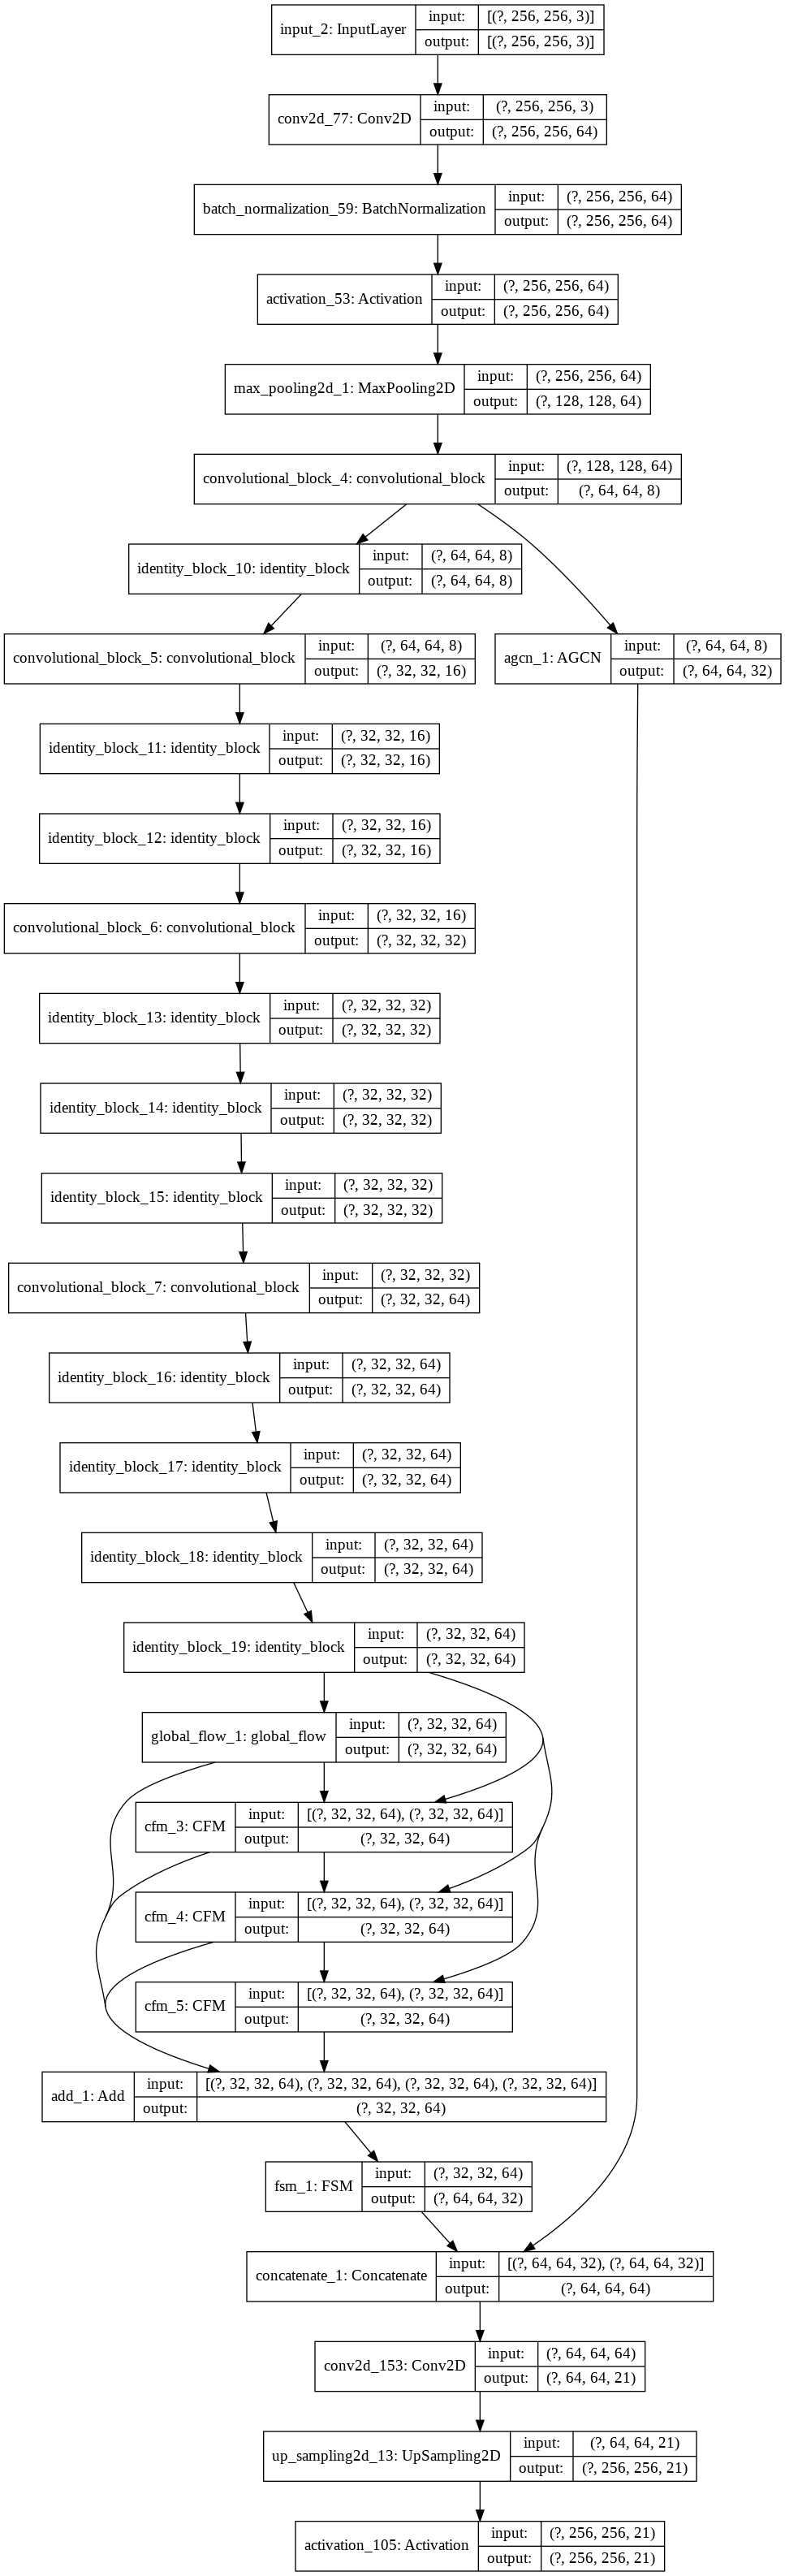

In [ ]:
tf.keras.utils.plot_model(
    model, to_file='model.png', show_shapes=True, show_layer_names=True,
    rankdir='TB',expand_nested=False)

In [36]:
import segmentation_models as sm
from segmentation_models.metrics import iou_score
from segmentation_models import Unet
import keras

In [42]:

ACCURACY_THRESHOLD_test = 0.8
class myCallback(tf.keras.callbacks.Callback): 
    def __init__(self):
      '''check'''


    def on_train_begin(self, logs={}):
        ## on begin of training, we are creating a instance varible called history
        ## it is a dict with keys [loss, acc, val_loss, val_acc]
        '''self.history={'loss': [],'IOU_Score': [],'val_loss': [],'Val_IOU_Score': []}'''
        self.best_val_iou = 0
        #self.model.save = model.save


    def on_epoch_end(self, epoch, logs=None):
        #print(logs.get('loss'))
        #print(logs.get('iou_score'))
        #print(logs.get('val_iou_score'))
        
        #print(self.best_val_iou)

        
        print(f"epoch: {epoch}, train_acc: {logs['iou_score']}, valid_acc: {logs['val_iou_score']}")

        if logs['val_iou_score'] > self.best_val_iou :
          print('Model accuarcy improved from {} to {}'.format(self.best_val_iou,logs['val_iou_score']))
          self.model.save_weights("best_model_CANET_NEW.h5", overwrite=True)
          self.best_val_iou = logs['val_iou_score']

        else:
          print('Model not improved from {}'.format(self.best_val_iou))  
          


        if(logs.get('val_iou_score') >= ACCURACY_THRESHOLD_test and logs.get('iou_score') >= ACCURACY_THRESHOLD_test): 
          print("\nReached %2.2f%% accuracy, so stopping training!!" %(ACCURACY_THRESHOLD_test*100))   
          self.model.stop_training = True

        #print('\n***'*50)
        

early_stop_iou_scores = myCallback()



In [2]:
# https://github.com/qubvel/segmentation_models
import segmentation_models as sm
from segmentation_models.metrics import iou_score
from segmentation_models import Unet
import keras


focal_loss = sm.losses.cce_dice_loss

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss 
# or total_loss = sm.losses.categorical_focal_dice_loss 

model_canet.compile(optimizer = 'adam', loss=focal_loss, metrics=[iou_score])

history = model_canet.fit_generator(train_dataloader, epochs=200,
                                    validation_data=test_dataloader, callbacks = [early_stop_iou_scores,early_stop ])


Epoch 1/200
100/100 [==============================] - ETA: 0s - loss: 2.0307 - iou_score: 0.0823epoch: 0, train_acc: 0.08229047060012817, valid_acc: 0.07771468162536621
Model accuarcy improved from 0 to 0.07771468162536621
100/100 [==============================] - 340s 3s/step - loss: 2.0307 - iou_score: 0.0823 - val_loss: 2.2454 - val_iou_score: 0.0777
Epoch 2/200
100/100 [==============================] - ETA: 0s - loss: 1.9901 - iou_score: 0.0857epoch: 1, train_acc: 0.08566392213106155, valid_acc: 0.08111810684204102
Model accuarcy improved from 0.07771468162536621 to 0.08111810684204102
100/100 [==============================] - 337s 3s/step - loss: 1.9901 - iou_score: 0.0857 - val_loss: 2.0586 - val_iou_score: 0.0811
Epoch 3/200
100/100 [==============================] - ETA: 0s - loss: 1.9827 - iou_score: 0.0861epoch: 2, train_acc: 0.08612792193889618, valid_acc: 0.09183380752801895
Model accuarcy improved from 0.08111810684204102 to 0.09183380752801895
100/100 [==============

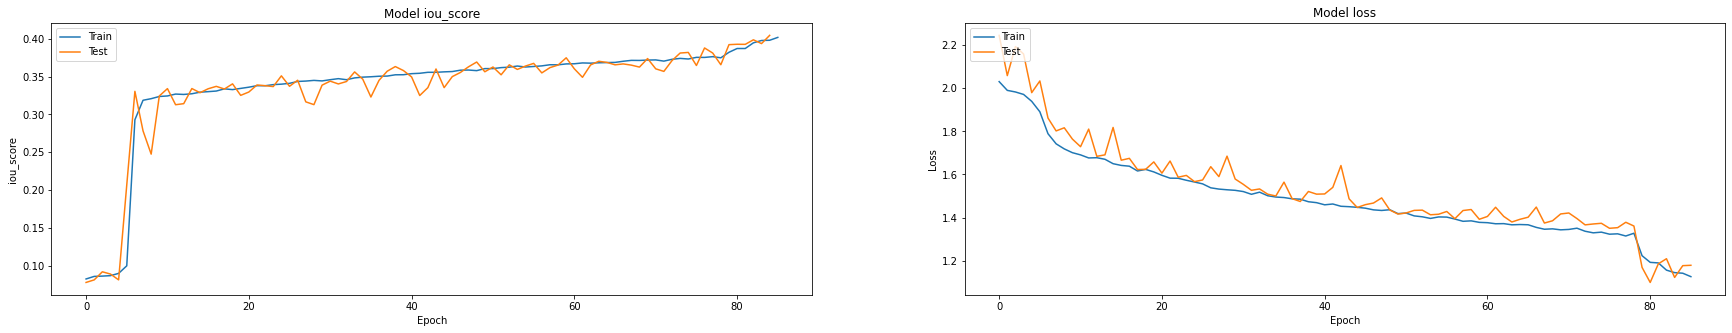

In [3]:
# Plot training & validation iou_score values
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

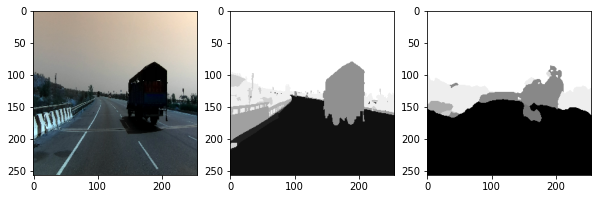

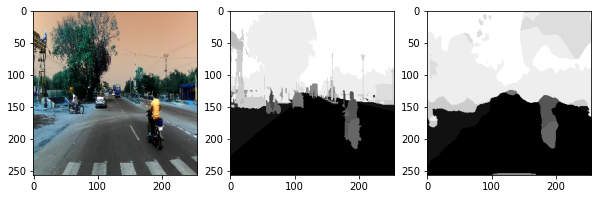

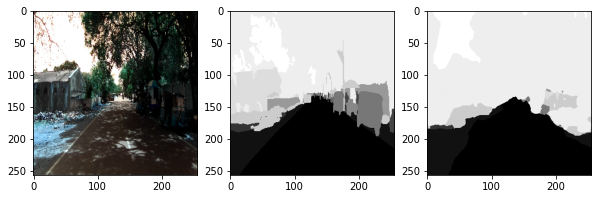

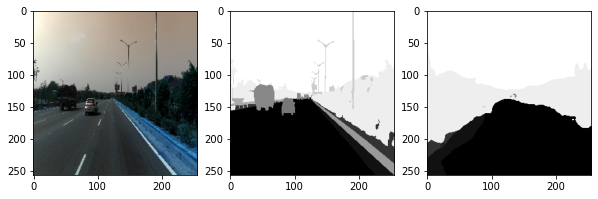

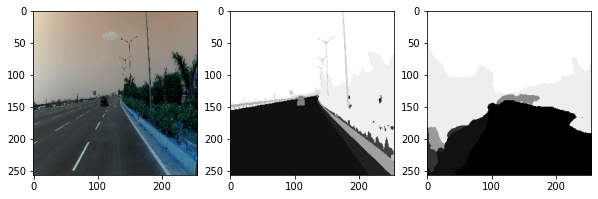

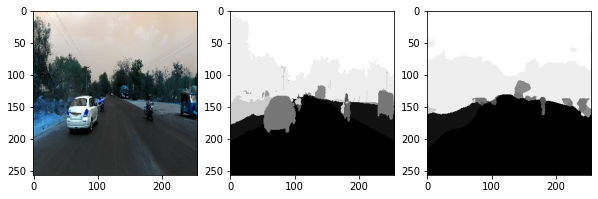

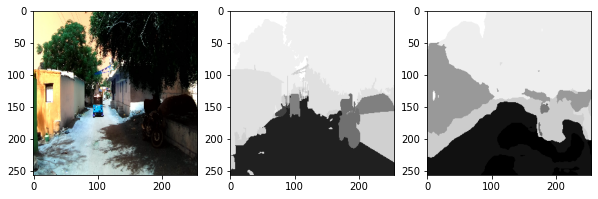

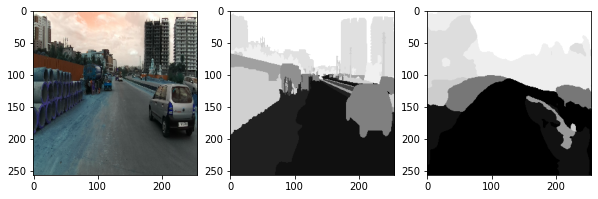

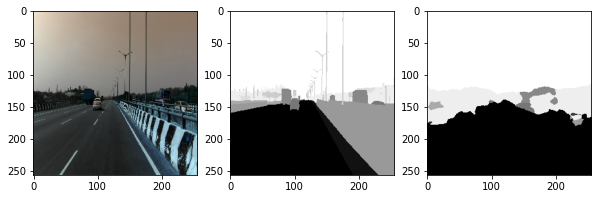

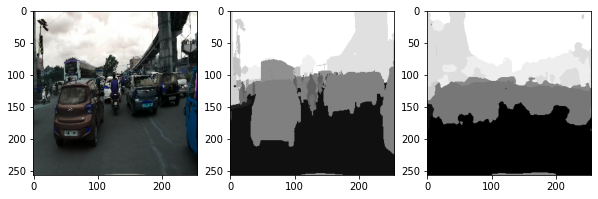

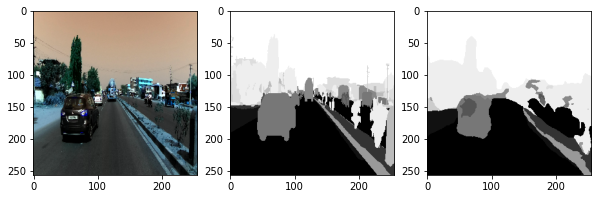

In [ ]:
for p, i in enumerate(X_train):
    #original image

    #image = cv2.imread(list(X_test['image'])[p], cv2.IMREAD_UNCHANGED)
    image = cv2.imread(os.path.join(dir_path, i+'_leftImg8bit.jpg'), cv2.IMREAD_UNCHANGED)
    image = cv2.resize(image, (256,256),interpolation = cv2.INTER_NEAREST) 
    
    #predicted segmentation map
    #print(np.newaxis)
    pred_mask  = model_canet.predict(image[np.newaxis,:,:,:])
    pred_mask = tf.argmax(pred_mask, axis=-1)
    
    #original segmentation map
    image_mask = cv2.imread(os.path.join(dir_path_output, i+'_gtFine_polygons.png'), cv2.IMREAD_UNCHANGED)
    image_mask = cv2.resize(image_mask, (256,256),interpolation = cv2.INTER_NEAREST)
    

    plt.figure(figsize=(10,6))
    plt.subplot(131)
    plt.imshow(image)
    plt.subplot(132)
    plt.imshow(image_mask, cmap='gray') 
    plt.subplot(133)
    plt.imshow(pred_mask[0], cmap='gray')
    plt.show()

    if p == 10:
      break